# Predicting diabetes using Percepton

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import torch


### 1. Import data and transform the data to csv

In [7]:
# from sklearn.datasets import load_svmlight_file
# X, y = load_svmlight_file("/Users/oliviachan/Documents/2024 Data Sci/Tri3/Deep Learning Fundamental/A1/diabetes.txt")
# print(X, y)

In [8]:
import csv
import numpy as np

def libsvm_to_csv(libsvm_file_path, csv_file_path, num_features):
    """
    Convert LIBSVM file to CSV format.

    Args:
        libsvm_file_path (str): Path to the LIBSVM formatted file.
        csv_file_path (str): Path where the CSV file will be saved.
        num_features (int): Total number of features in the dataset.
    """
    
    # Open the LIBSVM file and read lines
    with open(libsvm_file_path, 'r') as libsvm_file:
        lines = libsvm_file.readlines()

    # Prepare the data for CSV
    data = []

    for line in lines:
        # Split line into label and features
        line_parts = line.split()
        label = line_parts[0]  # First part is the label, omit"

        # Create a zero array for features
        features = np.zeros(num_features)

        for item in line_parts[1:]:
            if len(item.split(":")) == 2:
                index, value = item.split(":")
                index = int(index) - 1  # Convert to zero-based index
                value = float(value)
                features[index] = value

        # Append label and features as a new row in data
        row = [label] + list(features)
        data.append(row)

    # Write the data to a CSV file
    with open(csv_file_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['label'] + [f'feature_{i+1}' for i in range(num_features)])  # Write header
        writer.writerows(data)

libsvm_file_path = "/Users/oliviachan/Documents/2024 Data Sci/Tri3/Deep Learning Fundamental/A1/diabetes.txt"  
csv_file_path = "/Users/oliviachan/Documents/2024 Data Sci/Tri3/Deep Learning Fundamental/A1/data.csv"  # Path to save the output CSV file
num_features = 8  # Replace with the number of features in your dataset
libsvm_to_csv(libsvm_file_path, csv_file_path, num_features)


### 2. Data Preprocessing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   label      768 non-null    int64  
 1   feature_1  768 non-null    float64
 2   feature_2  768 non-null    float64
 3   feature_3  768 non-null    float64
 4   feature_4  768 non-null    float64
 5   feature_5  768 non-null    float64
 6   feature_6  768 non-null    float64
 7   feature_7  768 non-null    float64
 8   feature_8  768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB

 Data Summary:
            label   feature_1   feature_2   feature_3   feature_4   feature_5  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     0.302083    3.845052  120.894531   69.105469   20.536458   79.799479   
std      0.953903    3.369578   31.972618   19.355807   15.952218  115.244002   
min     -1.000000    0.000000    0.000000    0.000000    0.000000

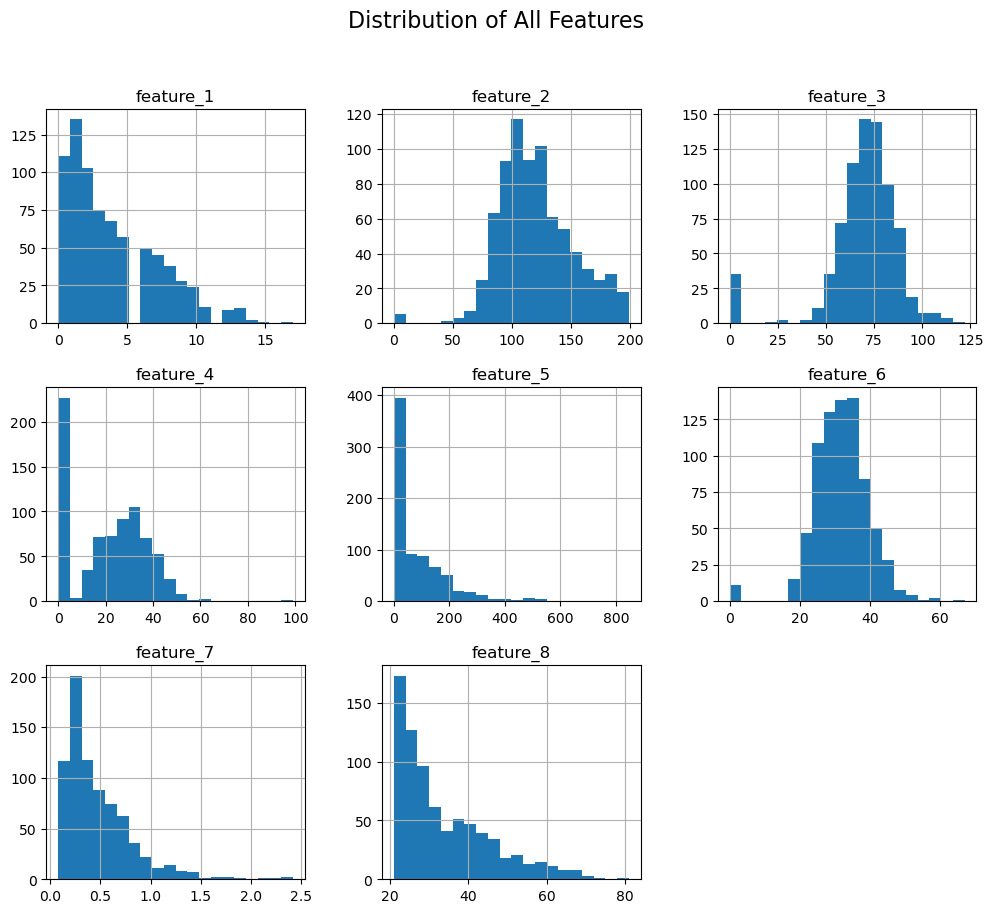

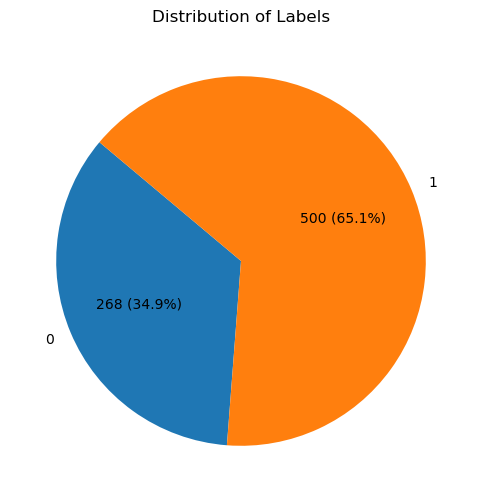

In [9]:
data = pd.read_csv('data.csv')
data.info()
print(f"\n Data Summary:")
print(data.describe())
print(f"\n Number of missing data:")

# Check for missing values in each column
missing_values = data.isnull().sum()

# Print the columns with missing values
print(missing_values)

X = data.drop("label", axis = 1)
y_before_converted = data["label"]

# Covert y from -1 and 1 to 0 and 1
y= (y_before_converted + 1) // 2

# Plot histograms for each feature
X.hist(figsize=(12, 10), bins=20)
plt.suptitle('Distribution of All Features', fontsize=16)
plt.show()


# Plot pie chart for label
labels, counts = np.unique(y, return_counts=True)
# Create a pie chart with both counts and percentages
def autopct_with_count(pct, allvalues):
    total = sum(allvalues)
    count = int(pct * total / 100.0)
    return f'{count} ({pct:.1f}%)'

plt.figure(figsize=(8, 6))
plt.pie(counts, labels=labels, autopct=lambda pct: autopct_with_count(pct, counts), startangle=140)
plt.title('Distribution of Labels')
plt.show()

### 3. Splitting data into train, test set
Since this is a small dataset, the proportion of train, test set is set to 70/30

In [12]:
from sklearn.model_selection import train_test_split
y = np.array(y)
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate proportions
train_proportion = X_train.shape[0] / X.shape[0]
test_proportion = X_test.shape[0] / X.shape[0]

print(f'Training set proportion: {train_proportion:.2f}')
print(f'Test set proportion: {test_proportion:.2f}')

# If X_train and X_test are DataFrames, convert them to NumPy arrays
X_train = X_train.to_numpy()  # Convert DataFrame to NumPy array
X_test = X_test.to_numpy()    # Convert DataFrame to NumPy array

# Convert target variables to PyTorch tensors and add dimension
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for binary output
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) 



Training set proportion: 0.70
Test set proportion: 0.30


### 4. Feature Scaling
Apply standardization after splitting the data to avoid data leakage

In [13]:
# Calculate the mean and standard deviation of the training set
mean = X_train_tensor.mean(dim=0)
std = X_train_tensor.std(dim=0)

# Standardize the training and test sets using the mean and std from the training set
X_train_tensor = (X_train_tensor - mean) / std
X_test_tensor= (X_test_tensor - mean) / std

### 5. Baseline model

In [20]:
def set_seed(seed_value = 69):
    # Set random seed for reproducibility
    torch.manual_seed(seed_value)  # For CPU
    torch.cuda.manual_seed_all(seed_value)  # For all GPUs (if using GPU)

    # Set seed for other libraries
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # NumPy


In [21]:
set_seed()

# Define the SLP model
class SLP_baseline(nn.Module):
    def __init__(self, input_size):
        super(SLP_baseline, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # Single layer

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Apply sigmoid for binary classification

# Initialize the model
input_size = X_train.shape[1]
baseline_model = SLP_baseline(input_size)
criterion = nn.BCELoss()

# Forward pass only (Baseline Model)
baseline_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    # Forward pass on the training set
    train_outputs = baseline_model(X_train_tensor)  # Forward pass through the training data
    train_predictions = (train_outputs >= 0.5).float()  # Convert probabilities to binary predictions
    
    # Calculate loss on the training set
    train_loss = criterion(train_outputs, y_train_tensor)
    print(f'Baseline Model Training Loss: {train_loss.item():.4f}')

    # Convert to CPU for sklearn metrics
    y_train_np = y_train_tensor.cpu().numpy()
    train_predictions_np = train_predictions.cpu().numpy()

    # Calculate accuracy, precision, recall, and F1 score on the training set
    train_accuracy = accuracy_score(y_train_np, train_predictions_np)
    train_precision = precision_score(y_train_np, train_predictions_np)
    train_recall = recall_score(y_train_np, train_predictions_np)
    f1_train = f1_score(y_train_np, train_predictions_np)
    
    print(f'Baseline Model Training Accuracy: {train_accuracy:.4f}')
    print(f'Baseline Model Training Precision: {train_precision:.4f}')
    print(f'Baseline Model Training Recall: {train_recall:.4f}')
    print(f'Baseline Model Training F1 Score: {f1_train:.4f}')


Baseline Model Training Loss: 0.7248
Baseline Model Training Accuracy: 0.5363
Baseline Model Training Precision: 0.6464
Baseline Model Training Recall: 0.6371
Baseline Model Training F1 Score: 0.6417


### 6. Hyperparameter Tuning

In [22]:
set_seed()

class SLP(nn.Module):
    def __init__(self, input_size):
        super(SLP, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # Assuming binary classification

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoid activation for binary output

# Function to train and evaluate the model
def train_and_evaluate_model(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    val_preds, val_labels, total_loss = [], [], 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_outputs = model(X_val)
            val_preds.append((val_outputs >= 0.5).float())
            val_labels.append(y_val)
            total_loss += criterion(val_outputs, y_val).item()  # Accumulate loss

    # Calculate average loss, precision, recall, F1 score, and accuracy
    avg_loss = total_loss / len(val_loader)
    val_preds = torch.cat(val_preds).cpu()
    val_labels = torch.cat(val_labels).cpu()
    
    precision = precision_score(val_labels, val_preds)
    recall = recall_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)
    accuracy = accuracy_score(val_labels, val_preds)

    return f1, avg_loss, accuracy, precision, recall  # Return F1 score, average loss, accuracy, precision, and recall


def perform_grid_search(X_train_tensor, y_train_tensor):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

    # Hyperparameter grid
    hyperparams = {
        'learning_rate': [0.1, 0.01, 0.001],
        'epochs': [10, 50, 100],
        'batch_size': [16, 32, 64],
        'weight_init': ['xavier', 'he', 'random'],
        'regularization': ['none', 'l1', 'l2'],
        'l1_reg': [0.0, 0.1, 0.01, 0.001],  # L1 regularization alpha values
        'l2_reg': [0.0, 0.1, 0.01, 0.001]   # L2 regularization alpha values
    }

    best_f1 = 0
    best_loss = float('inf')
    best_accuracy = 0
    best_params = {}
    results = []  # To store all results

    for lr in hyperparams['learning_rate']:
        for epochs in hyperparams['epochs']:
            for batch_size in hyperparams['batch_size']:
                for init in hyperparams['weight_init']:
                    for regularization in hyperparams['regularization']:
                        for reg_alpha in (hyperparams['l1_reg'] if regularization == 'l1' else hyperparams['l2_reg']):
                            fold_f1_scores = []
                            fold_losses = []
                            fold_accuracies = []
                            fold_precisions = []
                            fold_recalls = []

                            for train_index, val_index in skf.split(X_train_tensor, y_train_tensor):
                                X_fold_train, X_fold_val = X_train_tensor[train_index], X_train_tensor[val_index]
                                y_fold_train, y_fold_val = y_train_tensor[train_index], y_train_tensor[val_index]

                                # Initialize model
                                model = SLP(X_fold_train.shape[1])

                                # Weight initialization
                                if init == 'xavier':
                                    nn.init.xavier_uniform_(model.linear.weight)
                                elif init == 'he':
                                    nn.init.kaiming_uniform_(model.linear.weight)
                                elif init == 'random':
                                    nn.init.normal_(model.linear.weight)

                                # Loss function
                                criterion = nn.BCELoss()

                                # Initialize optimizer
                                optimizer = optim.SGD(model.parameters(), lr=lr)

                                # Create DataLoader for training and validation sets
                                train_dataset = torch.utils.data.TensorDataset(X_fold_train, y_fold_train)
                                val_dataset = torch.utils.data.TensorDataset(X_fold_val, y_fold_val)
                                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                                val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

                                # Train the model
                                for epoch in range(epochs):
                                    model.train()
                                    for X_batch, y_batch in train_loader:
                                        optimizer.zero_grad()
                                        outputs = model(X_batch)
                                        loss = criterion(outputs, y_batch)

                                        # Apply regularization
                                        if regularization == 'l1':
                                            penalty = reg_alpha * torch.sum(torch.abs(model.linear.weight))
                                        elif regularization == 'l2':
                                            penalty = reg_alpha * torch.sum(model.linear.weight ** 2)
                                        else:
                                            penalty = 0

                                        loss += penalty  # Add regularization penalty
                                        loss.backward()
                                        optimizer.step()

                                # Evaluate the model
                                fold_f1, fold_loss, fold_accuracy, fold_precision, fold_recall = train_and_evaluate_model(
                                    model, optimizer, criterion, train_loader, val_loader, epochs)
                                fold_f1_scores.append(fold_f1)
                                fold_losses.append(fold_loss)
                                fold_accuracies.append(fold_accuracy)
                                fold_precisions.append(fold_precision)
                                fold_recalls.append(fold_recall)

                            avg_f1 = np.mean(fold_f1_scores)
                            avg_loss = np.mean(fold_losses)
                            avg_accuracy = np.mean(fold_accuracies)
                            avg_precision = np.mean(fold_precisions)
                            avg_recall = np.mean(fold_recalls)

                            # Store results for this configuration
                            results.append({
                                'f1': avg_f1,
                                'loss': avg_loss,
                                'accuracy': avg_accuracy,
                                'precision': avg_precision,
                                'recall': avg_recall,
                                'params': {
                                    'learning_rate': lr,
                                    'epochs': epochs,
                                    'batch_size': batch_size,
                                    'weight_init': init,
                                    'regularization': regularization,
                                    'reg_alpha': reg_alpha  # Include alpha value for L1/L2 regularization
                                }
                            })

                            # Update best hyperparameters if necessary
                            if avg_f1 > best_f1 or (avg_f1 == best_f1 and avg_loss < best_loss):
                                best_f1 = avg_f1
                                best_loss = avg_loss
                                best_accuracy = avg_accuracy
                                best_params = {
                                    'learning_rate': lr,
                                    'epochs': epochs,
                                    'batch_size': batch_size,
                                    'weight_init': init,
                                    'regularization': regularization,
                                    'reg_alpha': reg_alpha  # Store alpha for L1/L2
                                }

    # Sort results based on F1 score and return the best 5 models
    results = sorted(results, key=lambda x: x['f1'], reverse=True)[:5]
    print(f'Top 5 models:')
    for result in results:
        print(f"F1: {result['f1']:.4f}, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, Accuracy: {result['accuracy']:.4f}, Params: {result['params']}")

    return best_params, results



best_hyperparams = perform_grid_search(X_train_tensor, y_train_tensor)

Top 5 models:
F1: 0.8388, Precision: 0.7922, Recall: 0.8914, Accuracy: 0.7766, Params: {'learning_rate': 0.1, 'epochs': 10, 'batch_size': 32, 'weight_init': 'random', 'regularization': 'none', 'reg_alpha': 0.001}
F1: 0.8376, Precision: 0.7905, Recall: 0.8914, Accuracy: 0.7747, Params: {'learning_rate': 0.01, 'epochs': 50, 'batch_size': 16, 'weight_init': 'random', 'regularization': 'l2', 'reg_alpha': 0.01}
F1: 0.8373, Precision: 0.7925, Recall: 0.8886, Accuracy: 0.7747, Params: {'learning_rate': 0.01, 'epochs': 50, 'batch_size': 16, 'weight_init': 'xavier', 'regularization': 'l2', 'reg_alpha': 0.001}
F1: 0.8368, Precision: 0.7936, Recall: 0.8857, Accuracy: 0.7747, Params: {'learning_rate': 0.1, 'epochs': 10, 'batch_size': 16, 'weight_init': 'he', 'regularization': 'l2', 'reg_alpha': 0.0}
F1: 0.8368, Precision: 0.7936, Recall: 0.8857, Accuracy: 0.7747, Params: {'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'weight_init': 'he', 'regularization': 'l1', 'reg_alpha': 0.01}


In [23]:
print(best_hyperparams[0])

{'learning_rate': 0.1, 'epochs': 10, 'batch_size': 32, 'weight_init': 'random', 'regularization': 'none', 'reg_alpha': 0.001}


### 7. Baseline Model and Best Model Performance Comparison

In [24]:
    # Forward pass on the test set
    test_outputs = baseline_model(X_test_tensor)  # Forward pass through the test data
    test_predictions = (test_outputs >= 0.5).float()  # Convert probabilities to binary predictions

    # Convert to CPU for sklearn metrics
    y_test_np = y_test_tensor.cpu().numpy()
    test_predictions_np = test_predictions.cpu().numpy()

    # Calculate accuracy, precision, recall, and F1 score on the test set
    test_accuracy = accuracy_score(y_test_np, test_predictions_np)
    test_precision = precision_score(y_test_np, test_predictions_np)
    test_recall = recall_score(y_test_np, test_predictions_np)
    f1_test = f1_score(y_test_np, test_predictions_np)
    
    print(f'Baseline Model Test Accuracy: {test_accuracy:.4f}')
    print(f'Baseline Model Test Precision: {test_precision:.4f}')
    print(f'Baseline Model Test Recall: {test_recall:.4f}')
    print(f'Baseline Model Test F1 Score: {f1_test:.4f}')

Baseline Model Test Accuracy: 0.5238
Baseline Model Test Precision: 0.6471
Baseline Model Test Recall: 0.5867
Baseline Model Test F1 Score: 0.6154


In [25]:
best_choice = best_hyperparams[0]

def apply_best_model_to_test(best_params, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    # Extract best hyperparameters
    lr = best_params['learning_rate']
    epochs = best_params['epochs']
    batch_size = best_params['batch_size']
    weight_init = best_params['weight_init']
    regularization = best_params['regularization']
    reg_alpha = best_params['reg_alpha']

    # Initialize the model
    model = SLP(X_train_tensor.shape[1])

    # Apply the weight initialization
    if weight_init == 'xavier':
        nn.init.xavier_uniform_(model.linear.weight)
    elif weight_init == 'he':
        nn.init.kaiming_uniform_(model.linear.weight)
    elif weight_init == 'random':
        nn.init.normal_(model.linear.weight)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Create DataLoader for the entire training set
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train the model on the entire training set
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Apply regularization if specified
            if regularization == 'l1':
                penalty = reg_alpha * torch.sum(torch.abs(model.linear.weight))
            elif regularization == 'l2':
                penalty = reg_alpha * torch.sum(model.linear.weight ** 2)
            else:
                penalty = 0  # No regularization

            loss += penalty
            loss.backward()
            optimizer.step()

    # After training, evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        test_outputs = model(X_test_tensor)  # Forward pass through the test data
        test_predictions = (test_outputs >= 0.5).float()  # Convert probabilities to binary predictions

        # Calculate Precision, Recall, F1 Score, and Accuracy
        precision = precision_score(y_test_tensor.cpu(), test_predictions.cpu())
        recall = recall_score(y_test_tensor.cpu(), test_predictions.cpu())
        f1 = f1_score(y_test_tensor.cpu(), test_predictions.cpu())
        accuracy = accuracy_score(y_test_tensor.cpu(), test_predictions.cpu())

        # Print the results
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")

    return precision, recall, f1, accuracy

# Example usage with the best hyperparameters
precision, recall, f1, accuracy = apply_best_model_to_test(best_choice, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)


Test Precision: 0.7987
Test Recall: 0.8467
Test F1 Score: 0.8220
Test Accuracy: 0.7619


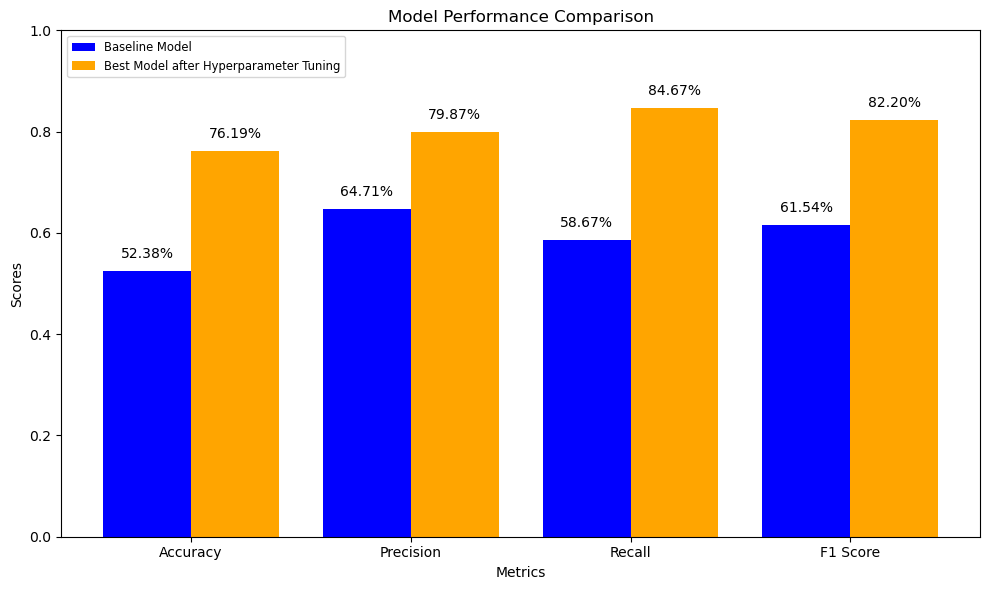

In [26]:
 import matplotlib.pyplot as plt

# Performance metrics for the baseline model
baseline_metrics = {
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1 Score': f1_test
}

# Performance metrics for the best model
best_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Prepare data for plotting
metrics = list(baseline_metrics.keys())
baseline_scores = list(baseline_metrics.values())
best_scores = list(best_metrics.values())

x = range(len(metrics))  # x-coordinates for the bars

# Create bar chart
plt.figure(figsize=(10, 6))
baseline_bars = plt.bar(x, baseline_scores, width=0.4, label='Baseline Model', color='blue', align='center')
best_bars = plt.bar([p + 0.4 for p in x], best_scores, width=0.4, label='Best Model after Hyperparameter Tuning', color='orange', align='center')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks([p + 0.2 for p in x], metrics)
plt.ylim(0, 1)  # Set y-axis limits to [0, 1] for better visualization

# Move legend to the upper left corner
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0, 1))

# Add percentages at the top of the bars
for bar in baseline_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2%}", ha='center', va='bottom')

for bar in best_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2%}", ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()
